# SCC5977 - Aprendizado de Máquina para Séries Temporais (2024)

## Grupo
> André Guarnier De Mitri - 11395579 \
> Fabio \
> Giovanni

## Problema
Incentia 11k euclidiana vs ddtw

# COMPARA TODAS AS SERIES DE TODAS AS CLASSES

Loaded 6000 time series with shape (1, 137).
Balanced dataset contains 6000 time series, 2000 per class.
Calculating Euclidean Distance...


Euclidean Distance: 100%|██████████| 17997000/17997000 [20:45<00:00, 14444.46it/s]


Euclidean Distance completed in 1245.95 seconds.
Calculating Derivative DTW Distance...


Derivative DTW Distance: 100%|██████████| 17997000/17997000 [2:14:38<00:00, 2227.71it/s]  


Derivative DTW Distance completed in 8078.71 seconds.

Euclidean Distance Analysis:
Median Distance: 2.5769
Smallest Distance: 0.0538 (between series 449 and 759)
Largest Distance: 15.1161 (between series 195 and 5597)

Derivative DTW Distance Analysis:
Median Distance: 0.1187
Smallest Distance: 0.0005 (between series 4398 and 4518)
Largest Distance: 3.6569 (between series 1082 and 4421)

Timing Analysis:
Euclidean Distance took 1245.95 seconds.
Derivative DTW Distance took 8078.71 seconds.


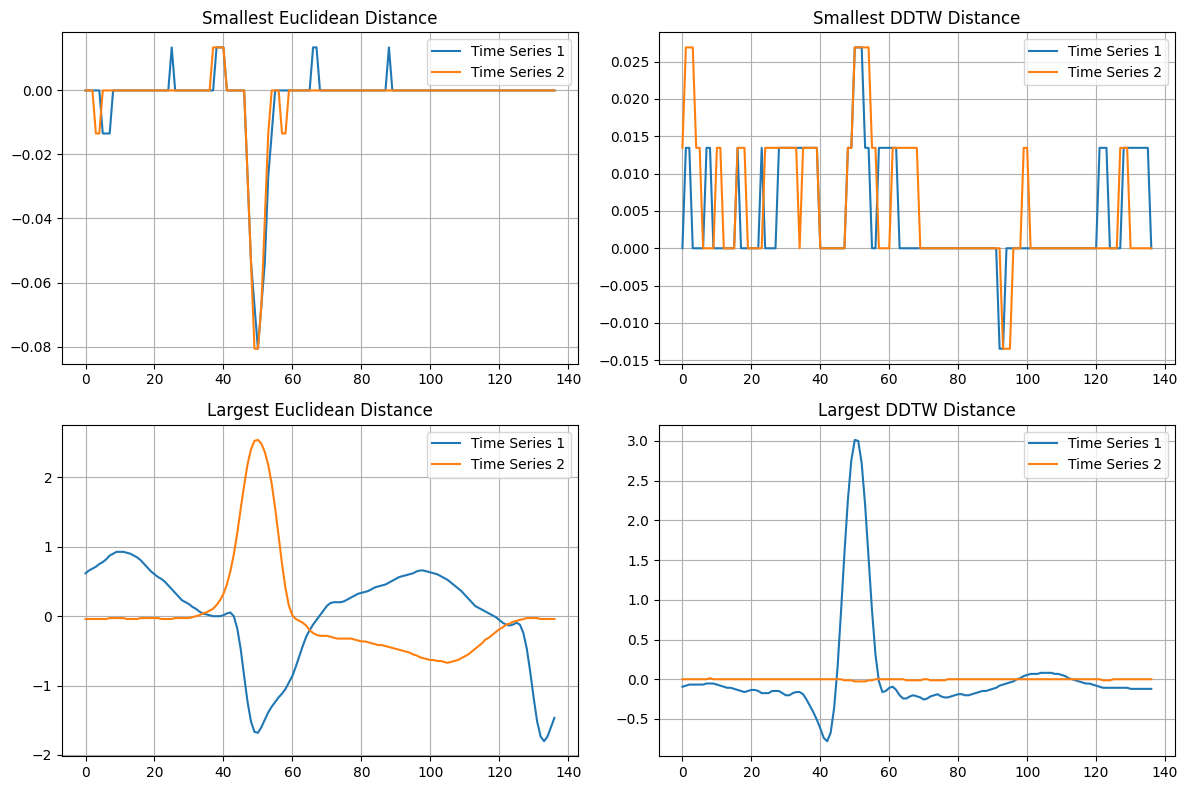

In [29]:
# Import necessary libraries
from aeon.distances import pairwise_distance, ddtw_distance
import numpy as np
from aeon.datasets import load_from_tsfile
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from sklearn.utils import resample


def load_and_validate_data(file_path):
    """Load and validate time series data with equal representation of classes."""
    X, y = load_from_tsfile(full_file_path_and_name=file_path)
    print(f"Loaded {X.shape[0]} time series with shape {X.shape[1:]}.")
    
    # Number of classes to include
    num_samples_per_class = 2000
    unique_classes = np.unique(y)
    balanced_indices = []

    for cls in unique_classes:
        # Get indices of the current class
        class_indices = np.where(y == cls)[0]
        # Sample exactly num_samples_per_class
        sampled_indices = resample(class_indices, n_samples=num_samples_per_class, random_state=42, replace=False)
        balanced_indices.extend(sampled_indices)

    # Create the balanced dataset
    balanced_indices = np.array(balanced_indices)
    X_balanced = X[balanced_indices]
    y_balanced = y[balanced_indices]

    print(f"Balanced dataset contains {len(balanced_indices)} time series, {num_samples_per_class} per class.")
    return X_balanced, y_balanced

def calculate_distances(X, metric_function, metric_name):
    """Calculate pairwise distances using the specified metric with progress tracking."""
    num_ts = X.shape[0]
    total_combinations = (num_ts * (num_ts - 1)) // 2  # Number of combinations

    print(f"Calculating {metric_name}...")
    distances = []
    start_time = time.time()

    with tqdm(total=total_combinations, desc=metric_name) as pbar:
        for (i, ts1), (j, ts2) in combinations(enumerate(X[:, 0]), 2):
            distances.append((float(metric_function(ts1, ts2)), i, j))
            pbar.update(1)  # Update the progress bar

    elapsed_time = time.time() - start_time
    print(f"{metric_name} completed in {elapsed_time:.2f} seconds.")
    return distances, elapsed_time

def summarize_distances(distances, distance_type):
    """Summarize and print statistics for the given distances."""
    distances_only = [d[0] for d in distances]
    smallest = min(distances, key=lambda x: x[0])
    largest = max(distances, key=lambda x: x[0])
    median_dist = np.median(distances_only)

    print(f"\n{distance_type} Analysis:")
    print(f"Median Distance: {median_dist:.4f}")
    print(f"Smallest Distance: {smallest[0]:.4f} (between series {smallest[1]} and {smallest[2]})")
    print(f"Largest Distance: {largest[0]:.4f} (between series {largest[1]} and {largest[2]})")

    return smallest, largest


def plot_time_series_comparison(X, pair, title, axs):
    """Plot two time series with a title."""
    ts1, ts2 = X[pair[1], 0], X[pair[2], 0]
    axs.plot(ts1, label="Time Series 1")
    axs.plot(ts2, label="Time Series 2")
    axs.set_title(title)
    axs.legend()
    axs.grid(True)


def main():
    # Load data
    file_path = './data/ts_files/train.ts'
    X, y = load_and_validate_data(file_path)

    # Calculate distances
    euclidean_distances, euclidean_time = calculate_distances(
        X, lambda x, y: pairwise_distance(x, y, metric="euclidean"), "Euclidean Distance"
    )
    ddtw_distances, ddtw_time = calculate_distances(X, ddtw_distance, "Derivative DTW Distance")

    # Summarize distances
    euclidean_smallest, euclidean_largest = summarize_distances(euclidean_distances, "Euclidean Distance")
    ddtw_smallest, ddtw_largest = summarize_distances(ddtw_distances, "Derivative DTW Distance")

    # Print time analysis
    print(f"\nTiming Analysis:")
    print(f"Euclidean Distance took {euclidean_time:.2f} seconds.")
    print(f"Derivative DTW Distance took {ddtw_time:.2f} seconds.")

    # Plot the time series comparisons
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    plot_time_series_comparison(X, euclidean_smallest, "Smallest Euclidean Distance", axs[0, 0])
    plot_time_series_comparison(X, ddtw_smallest, "Smallest DDTW Distance", axs[0, 1])
    plot_time_series_comparison(X, euclidean_largest, "Largest Euclidean Distance", axs[1, 0])
    plot_time_series_comparison(X, ddtw_largest, "Largest DDTW Distance", axs[1, 1])

    plt.tight_layout()
    plt.show()

# Run the main function
main()

# COMPARA AS SERIES SEPARADAS POR CLASSE

In [ ]:
def calculate_class_distances_and_plot(X, metric_function, metric_name, class_name, axs):
    """Calculate distances for a specific class and generate corresponding plots."""
    print(f"\nProcessing class '{class_name}' with {metric_name}...")

    if X.shape[0] < 2:
        print(f"Class '{class_name}' has fewer than 2 time series, skipping.")
        return None

    distances, _ = calculate_distances(X, metric_function, f"{metric_name} for class {class_name}")
    smallest, largest = summarize_distances(distances, f"{metric_name} for class {class_name}")

    # Plotting
    plot_time_series_comparison(X, smallest, f"Class {class_name}: Smallest {metric_name}", axs[0])
    plot_time_series_comparison(X, largest, f"Class {class_name}: Largest {metric_name}", axs[1])

    return distances


def get_samples_per_class(X, y, target_class, sample_size=2000):
    """Get up to sample_size time series for the specified class."""
    class_indices = np.where(y == target_class)[0]
    class_ts = X[class_indices]

    if len(class_ts) > sample_size:
        # Randomly sample without replacement
        sampled_ts = resample(class_ts, n_samples=sample_size, replace=False, random_state=42)
    else:
        sampled_ts = class_ts

    return sampled_ts


def main():
    # Load data
    file_path = './data/ts_files/train.ts'
    X, y = load_from_tsfile(full_file_path_and_name=file_path)
    print(f"Loaded {X.shape[0]} time series with {len(np.unique(y))} classes: {np.unique(y)}.")

    # Define classes
    classes = ['n', 'v', 's']
    sample_size = 2000

    # Extract and combine 100 samples per class
    X_samples, y_samples = [], []

    for cls in classes:
        print(f"Sampling for class '{cls}'...")
        X_cls = get_samples_per_class(X, y, cls, sample_size)
        y_cls = np.full(X_cls.shape[0], cls)  # Assign class label to each sample
        X_samples.append(X_cls)
        y_samples.append(y_cls)

    # Combine all samples
    X_samples = np.concatenate(X_samples)
    y_samples = np.concatenate(y_samples)

    print(f"Sampled {X_samples.shape[0]} time series ({sample_size} from each class).")

    # Calculate global distances
    euclidean_distances, euclidean_time = calculate_distances(
        X_samples, lambda x, y: pairwise_distance(x, y, metric="euclidean"), "Euclidean Distance"
    )
    ddtw_distances, ddtw_time = calculate_distances(X_samples, ddtw_distance, "Derivative DTW Distance")

    # Summarize global distances
    euclidean_smallest, euclidean_largest = summarize_distances(euclidean_distances, "Euclidean Distance")
    ddtw_smallest, ddtw_largest = summarize_distances(ddtw_distances, "Derivative DTW Distance")

    # Print timing analysis
    print(f"\nTiming Analysis:")
    print(f"Euclidean Distance took {euclidean_time:.2f} seconds.")
    print(f"Derivative DTW Distance took {ddtw_time:.2f} seconds.")

    # Class-Based Analysis and Plots
    print("\nClass-Based Distance Analysis and Plots")
    fig, axs = plt.subplots(len(classes), 4, figsize=(16, 4 * len(classes)))

    for idx, cls in enumerate(classes):
        print(f"\nAnalyzing class '{cls}':")
        # Filter samples for the class
        X_cls = X_samples[np.where(y_samples == cls)[0]]

        # Plot Euclidean Distance
        calculate_class_distances_and_plot(
            X_cls, lambda x, y: pairwise_distance(x, y, metric="euclidean"),
            "Euclidean Distance", cls, axs[idx, :2]
        )
        # Plot DDTW Distance
        calculate_class_distances_and_plot(
            X_cls, ddtw_distance, "Derivative DTW Distance", cls, axs[idx, 2:]
        )

    # Display the global plots
    fig.tight_layout()
    plt.show()


# Run the main function
main()

Loaded 6000 time series with 3 classes: ['n' 's' 'v'].
Sampling for class 'n'...
Sampling for class 'v'...
Sampling for class 's'...
Sampled 6000 time series (2000 from each class).
Calculating Euclidean Distance...


Euclidean Distance:   5%|▍         | 851022/17997000 [00:57<19:19, 14791.80it/s]

### O QUÃO SIMILAR É CADA CLASSE

In [ ]:
from collections import Counter
from random import sample
import numpy as np
import matplotlib.pyplot as plt

def calculate_class_similarities(X, y, metric_function, metric_name):
    """Calculate pairwise distances within sampled instances of each class."""
    unique_classes = np.unique(y)
    class_samples = {}
    class_distances = {}

    for class_label in unique_classes:
        # Filter indices for the current class
        class_indices = np.where(y == class_label)[0]
        
        # Randomly sample 5 instances from the class
        sampled_indices = sample(list(class_indices), min(5, len(class_indices)))
        class_samples[class_label] = sampled_indices
        
        # Calculate distances within the sampled class
        distances = []
        for (i, ts1), (j, ts2) in combinations(enumerate(X[sampled_indices, 0]), 2):
            distances.append(float(metric_function(ts1, ts2)))

        class_distances[class_label] = distances

    # Summarize results
    for class_label, distances in class_distances.items():
        if distances:
            median_dist = np.median(distances)
            mean_dist = np.mean(distances)
            print(f"\nClass {class_label} ({metric_name}):")
            print(f"  Median Distance: {median_dist:.4f}")
            print(f"  Mean Distance: {mean_dist:.4f}")
        else:
            print(f"\nClass {class_label}: Insufficient data for calculation.")

    return class_samples, class_distances

def main_similarity_analysis():
    # Load data
    file_path = './data/ts_files/train.ts'
    X, y = load_from_tsfile(full_file_path_and_name=file_path)

    # Analyze similarities for each class
    print("\n=== Similarity Analysis ===")
    
    # Euclidean
    calculate_class_similarities(
        X, y,
        lambda x, y: pairwise_distance(x, y, metric="euclidean"),
        "Euclidean Distance"
    )

    # Derivative DTW
    calculate_class_similarities(
        X, y,
        ddtw_distance,
        "Derivative DTW Distance"
    )

main_similarity_analysis()


=== Similarity Analysis ===

Class n (Euclidean Distance):
  Median Distance: 1.2847
  Mean Distance: 1.4488

Class s (Euclidean Distance):
  Median Distance: 2.5617
  Mean Distance: 2.7729

Class v (Euclidean Distance):
  Median Distance: 3.8290
  Mean Distance: 4.3693

Class n (Derivative DTW Distance):
  Median Distance: 0.0631
  Mean Distance: 0.1071

Class s (Derivative DTW Distance):
  Median Distance: 0.1545
  Mean Distance: 0.2923

Class v (Derivative DTW Distance):
  Median Distance: 0.0569
  Mean Distance: 0.0739


# Trabalhos relacionados

# Algoritimos Utilizados
> DDTW \
> Baseline Euclidiana

# Metodologia

O conjunto de dados usado nesse cenário foi o Icentia11k, um banco de dados com sinais contínuos de ECG brutos, amostrados a 250Hz, abrangendo 11.000 pacientes e 2 bilhões de batimentos anotados.

Por conta dos custos computacionais, limitamos nossa análise aos primeiros 1.000 pacientes. No entanto, embora todos os pacientes tivessem as localizações dos batimentos anotadas por especialistas, a maioria não tinha rótulos de classe ou informações para outras categorias. No final, trabalhamos com 210 pacientes com batimentos anotados nas classes normal, PAC ou PVC.

Os passos de pré-processamento seguiram procedimentos semelhantes aos usados no Banco de Dados Europeu ST-T. Dividimos os pacientes em conjuntos de treinamento e teste, garantindo que cada paciente contribuísse apenas com batimentos de uma única classe. Além disso, descartamos os dois primeiros e os dois últimos batimentos de cada gravação. Após esse processo, obtivemos um conjunto com 168 pacientes para treinamento, com 2.000 batimentos por classe, e 42 pacientes para teste, com 500 batimentos por classe.

## Carregando o dataset

# Resultados e Discussões